In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
from lib import data
from lib import sar
from lib import io
from lib import trainer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from progressbar import progressbar as pbar
from importlib import reload

$$
C=
\begin{bmatrix}
\langle |S_{HH}|^2 \rangle & \sqrt{2} \langle S_{HH}S^{*}_{HV} \rangle &  \langle S_{HH}S^{*}_{VV}\rangle \\
\sqrt{2} \langle S_{HV}S^{*}_{HH} \rangle &  2 \langle |S_{HV}|^2 \rangle  & \sqrt{2} \langle S_{HV}S^{*}_{VV} \rangle \\
\langle S_{VV}S^{*}_{HH} \rangle & \sqrt{2} \langle S_{VV}S^{*}_{HV}\rangle & \langle |S_{VV}|^2 \rangle
\end{bmatrix}
$$

## load train and test images

In [2]:
base_path = "/home/rlx/data/sar-recovery"
date_train = '20100520'
date_test  = '20120720'

window_size = 7

In [4]:
wcmtr = sar.avgpool2D_complex(sar.compute_coherence_matrix(smtr), window_size=7)
wcmts = sar.avgpool2D_complex(sar.compute_coherence_matrix(smts), window_size=7)

In [5]:
wcmtr.shape, wcmts.shape

((628, 228, 3, 3), (628, 228, 3, 3))

## define train/test/val split mask

may use spatial split to attempt to avoid spatial leakage between train, test, val

In [7]:
h, w, _, _ = wcmtr.shape

splitmask_random = data.cv_splitpixels_random(h, w, train_pct = .70, test_pct = .15, val_pct = .15)
splitmask_bands  = data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)

TRAIN, TEST, VAL = 0,1,2

In [9]:
Shhtr = wcmtr[:,:,0,0].real
Shhts = wcmts[:,:,0,0].real


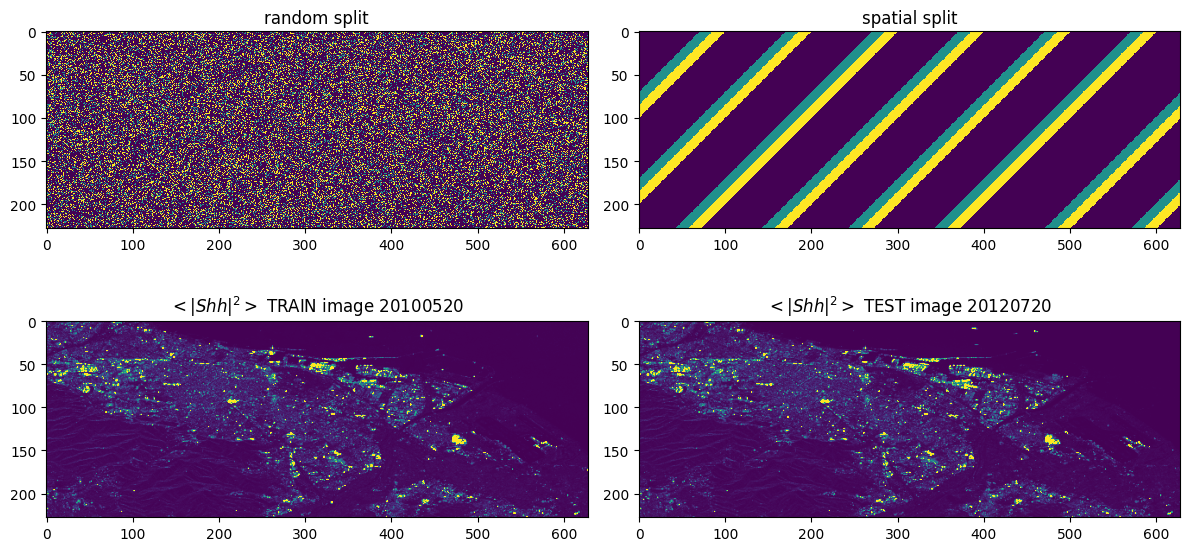

In [16]:
a,b = np.percentile(list(Shhtr.flatten()) + list(Shhts.flatten()), [1,99])

for ax, i in subplots(4, usizex=6, n_cols=2):
    if i==0: plt.imshow(splitmask_random.T, interpolation='none'); plt.title("random split")
    if i==1: plt.imshow(splitmask_bands.T, interpolation='none'); plt.title("spatial split")
    if i==2: plt.imshow(Shhtr.T, vmin=a, vmax=b); plt.title(f"$ <|Shh|^2> $ TRAIN image {date_train}") 
    if i==3: plt.imshow(Shhts.T, vmin=a, vmax=b); plt.title(f"$ <|Shh|^2> $ TEST image {date_test}") 

## train random forest

**input**: 

- $\langle |S_{vv}|^2\rangle$ (real)
- $2\langle |S_{hv}|^2\rangle$ (real)
- $\sqrt{2} \langle S_{HV}S^{*}_{VV} \rangle$ (real and imag)

**prediction**: 

- $\langle |S_{hh}|^2\rangle$ (real)


In [140]:
reload(trainer)
#splitmask = splitmask_bands
splitmask = splitmask_random
t = trainer.Trainer(wcmtr, wcmts, splitmask, 
                    input_features=['Svv', 'Shv', 'ShvSvv'], 
                    feature_to_predict='Shh', 
                    fit_log = False).split()
t.xtr.shape, t.xts.shape, t.ytr.shape, t.yts.shape

((100080, 4), (21535, 4), (100080,), (21535,))

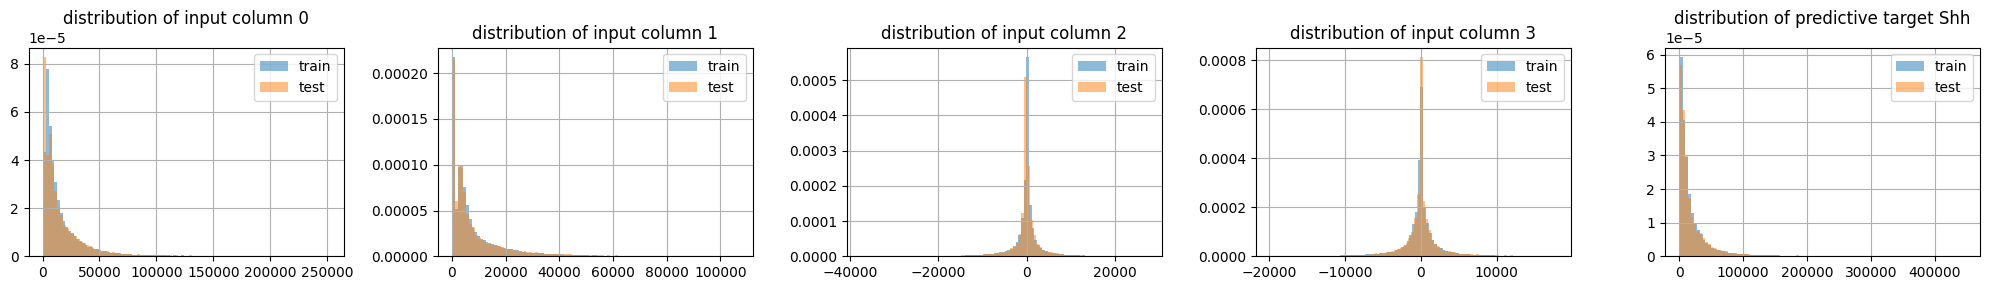

In [141]:
t.plot_distributions()

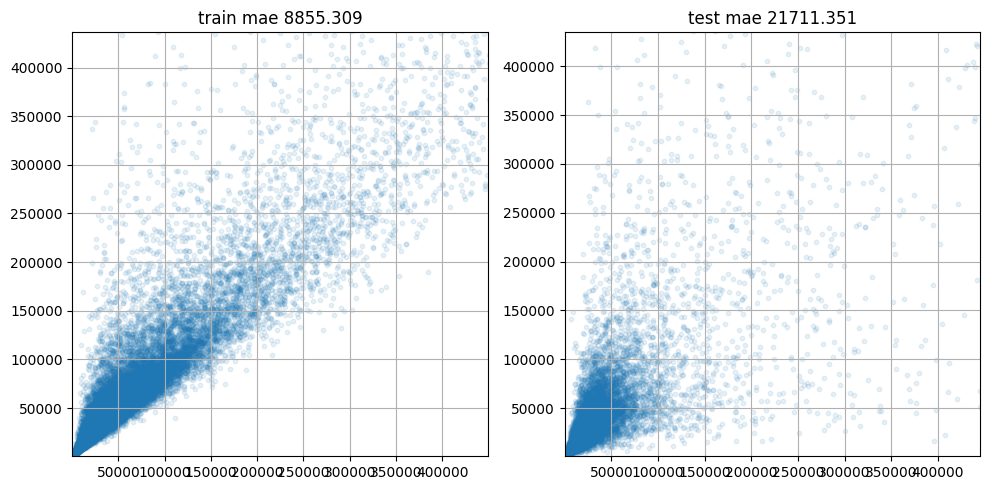

In [143]:
t.set_estimator(RandomForestRegressor(max_depth=40, n_estimators=20, n_jobs=6))
t.fit()
t.plot_predictions()

### with different split masks

In [170]:
t = trainer.Trainer(wcmtr, wcmts, splitmask_random,  input_features=['Svv', 'Shv', 'ShvSvv'], feature_to_predict='Shh', 
                    fit_log = False).split()
t.set_estimator(RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=6)).fit()
print (f"splitmask random train err {t.errtr:.3f}    test err {t.errts:.3f}")

splitmask random train err 8655.995    test err 21604.659


In [171]:
t = trainer.Trainer(wcmtr, wcmts, splitmask_bands,  input_features=['Svv', 'Shv', 'ShvSvv'], feature_to_predict='Shh', 
                    fit_log = False).split()
t.set_estimator(RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=6)).fit()
print (f"splitmask bands train err {t.errtr:.3f}    test err {t.errts:.3f}")

splitmask bands train err 8732.169    test err 22398.971


### predict log

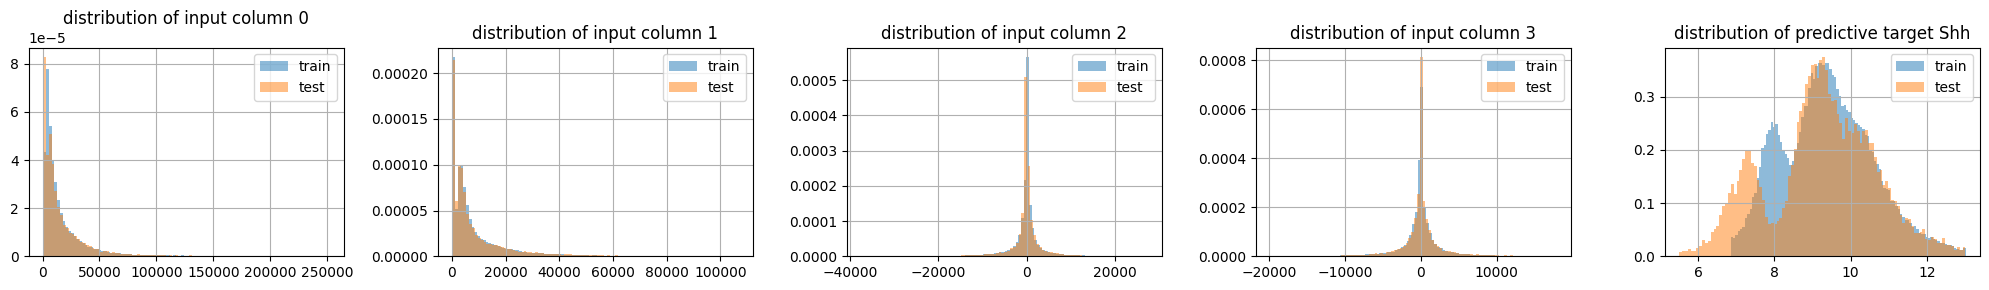

In [159]:
reload(trainer)
splitmask = splitmask_random
t = trainer.Trainer(wcmtr, wcmts, splitmask, 
                    input_features=['Svv', 'Shv', 'ShvSvv'], 
                    feature_to_predict='Shh', 
                    fit_log = True).split()
t.plot_distributions()

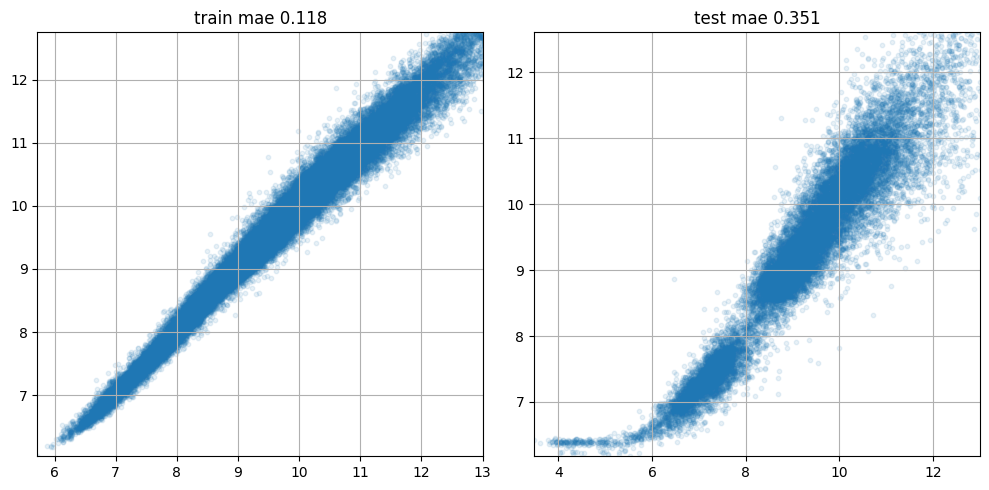

In [160]:
t.set_estimator(RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=6))
t.fit()
t.plot_predictions()

### but taking the predictions to the original space (`np.exp`) yields similar error


In [147]:

print (f"error in log space,      train {np.abs(t.ytr-t.predstr).mean():.3f}    test {np.abs(t.yts-t.predsts).mean():.3f}")
print (f"error in original space, train {np.abs(np.exp(t.ytr)-np.exp(t.predstr)).mean():.3f}    test {np.abs(np.exp(t.yts)-np.exp(t.predsts)).mean():.3f}")

error in log space,      train 0.119    test 0.343
error in original space, train 9046.249    test 17873.909


### with different split masks in log space

In [172]:
t = trainer.Trainer(wcmtr, wcmts, splitmask_random,  input_features=['Svv', 'Shv', 'ShvSvv'], feature_to_predict='Shh', 
                    fit_log = True).split()
t.set_estimator(RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=6)).fit()
print (f"splitmask random train err {t.errtr:.3f}    test err {t.errts:.3f}")

splitmask random train err 0.118    test err 0.351


In [173]:
t = trainer.Trainer(wcmtr, wcmts, splitmask_bands,  input_features=['Svv', 'Shv', 'ShvSvv'], feature_to_predict='Shh', 
                    fit_log = True).split()
t.set_estimator(RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=6)).fit()
print (f"splitmask bands train err {t.errtr:.3f}    test err {t.errts:.3f}")

splitmask bands train err 0.119    test err 0.344


## taking the same image for train and test

In [174]:
t = trainer.Trainer(wcmtr, wcmtr, splitmask_random,  input_features=['Svv', 'Shv', 'ShvSvv'], feature_to_predict='Shh', 
                    fit_log = True).split()
t.set_estimator(RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=6)).fit()
print (f"splitmask random train err {t.errtr:.3f}    test err {t.errts:.3f}")

splitmask random train err 0.118    test err 0.310


In [175]:
t = trainer.Trainer(wcmtr, wcmtr, splitmask_bands,  input_features=['Svv', 'Shv', 'ShvSvv'], feature_to_predict='Shh', 
                    fit_log = True).split()
t.set_estimator(RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=6)).fit()
print (f"splitmask bands train err {t.errtr:.3f}    test err {t.errts:.3f}")

splitmask bands train err 0.119    test err 0.309


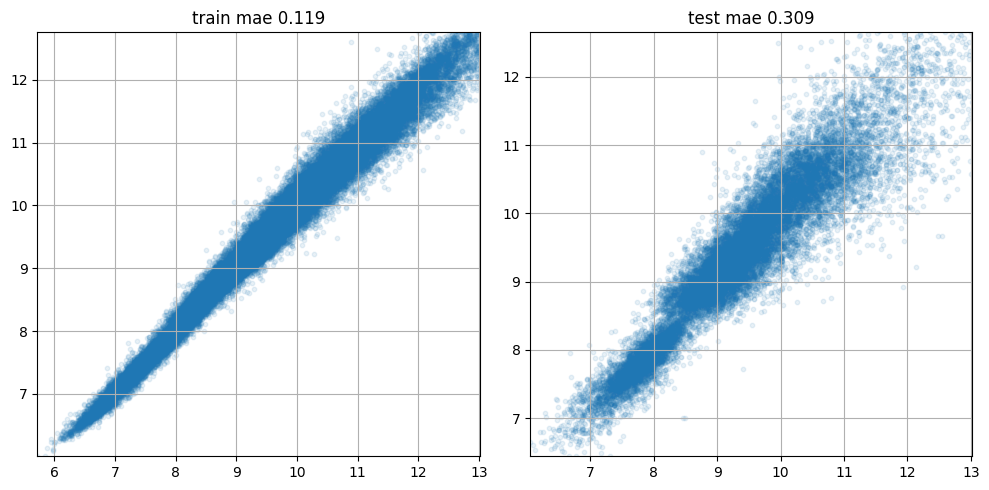

In [176]:
t.plot_predictions()

## Random Forest complexity curves

In [98]:
def plot_complexity_curve(t):
    depths = list(range(1,100,5))
    errs = []
    for depth in pbar(depths):
        t.set_estimator(RandomForestRegressor(max_depth=depth, n_estimators=20, n_jobs=6))
        t.fit()
        errs.append([t.errtr, t.errts])
    errs = np.r_[errs]
    errs_tr = errs[:,0]
    errs_ts = errs[:,1]

    plt.plot(depths, errs_tr, label='train')
    plt.plot(depths, errs_ts, label='test')
    plt.grid();
    plt.xlabel("RF max depth")
    plt.ylabel("mean absolute error")
    plt.legend()

100% (20 of 20) |########################| Elapsed Time: 0:00:39 Time:  0:00:39


Text(0.5, 1.0, 'predicting log')

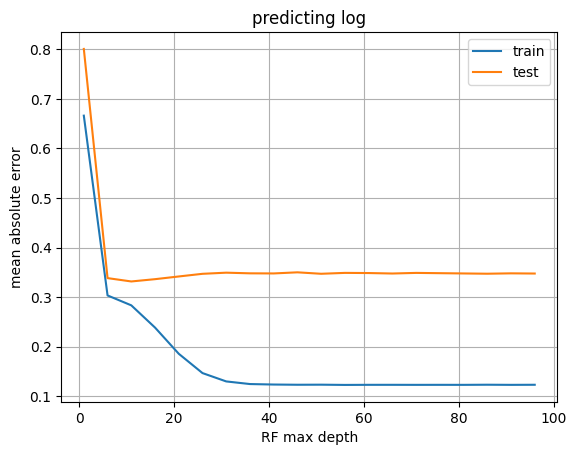

In [101]:
t = trainer.Trainer(wcmtr, wcmts, splitmask, 
                    input_features=['Svv', 'Shv', 'ShvSvv'], 
                    feature_to_predict='Shh', 
                    fit_log = True).split()

plot_complexity_curve(t)
plt.title("predicting log")

100% (20 of 20) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


Text(0.5, 1.0, 'predicting original value')

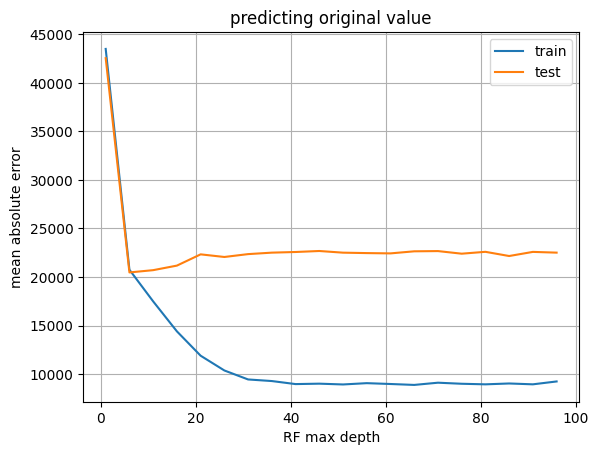

In [134]:
t = trainer.Trainer(wcmtr, wcmts, splitmask, 
                    input_features=['Svv', 'Shv', 'ShvSvv'], 
                    feature_to_predict='Shh', 
                    fit_log = False).split()

plot_complexity_curve(t)
plt.title("predicting original value")